# Проектная работа: "Принятие решений в бизнесе."

### Задача: Приоритизировать  гипотезы, запустить A/B-тест и проанализировать результаты. 

### Импортируем необходимые библиотеки  и загружаем датасеты 

In [1]:
import pandas as pd
import scipy.stats as stats
import datetime as dt
import numpy as np
import matplotlib.pyplot as plt
from pandas.plotting import register_matplotlib_converters
import warnings
register_matplotlib_converters()

In [2]:
try:
    hypothesis = pd.read_csv('hypothesis.csv')
except:
    hypothesis = pd.read_csv('https://code.s3.yandex.net/datasets/hypothesis.csv')

In [3]:
try: 
    orders = pd.read_csv('orders.csv')
except: 
    orders = pd.read_csv('https://code.s3.yandex.net/datasets/orders.csv')

In [4]:
try:
    visitors = pd.read_csv('visitors.csv')
except:
    visitors = pd.read_csv('https://code.s3.yandex.net/datasets/visitors.csv')

In [5]:
#Выводим первые пять строк датасетов
display(hypothesis.head(5))
display(orders.head(5))
display(visitors.head(5))

,Hypothesis,Reach,Impact,Confidence,Efforts
0,"Добавить два новых канала привлечения трафика,...",3,10,8,6
1,"Запустить собственную службу доставки, что сок...",2,5,4,10
2,Добавить блоки рекомендаций товаров на сайт ин...,8,3,7,3
3,"Изменить структура категорий, что увеличит кон...",8,3,3,8
4,"Изменить цвет фона главной страницы, чтобы уве...",3,1,1,1


,transactionId,visitorId,date,revenue,group
0,3667963787,3312258926,2019-08-15,1650,B
1,2804400009,3642806036,2019-08-15,730,B
2,2961555356,4069496402,2019-08-15,400,A
3,3797467345,1196621759,2019-08-15,9759,B
4,2282983706,2322279887,2019-08-15,2308,B


,date,group,visitors
0,2019-08-01,A,719
1,2019-08-02,A,619
2,2019-08-03,A,507
3,2019-08-04,A,717
4,2019-08-05,A,756


## 1. Предобработка данных 

In [6]:
#Выведем общую информацию о датасетах
display(hypothesis.info())
display(orders.info())
display(visitors.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9 entries, 0 to 8
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Hypothesis  9 non-null      object
 1   Reach       9 non-null      int64 
 2   Impact      9 non-null      int64 
 3   Confidence  9 non-null      int64 
 4   Efforts     9 non-null      int64 
dtypes: int64(4), object(1)
memory usage: 488.0+ bytes


None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   transactionId  1197 non-null   int64 
 1   visitorId      1197 non-null   int64 
 2   date           1197 non-null   object
 3   revenue        1197 non-null   int64 
 4   group          1197 non-null   object
dtypes: int64(3), object(2)
memory usage: 46.9+ KB


None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   date      62 non-null     object
 1   group     62 non-null     object
 2   visitors  62 non-null     int64 
dtypes: int64(1), object(2)
memory usage: 1.6+ KB


None

In [7]:
#проверим датасеты на наличие пропусков
display(hypothesis.isna().sum())
display(orders.isna().sum())
display(visitors.isna().sum())

Hypothesis    0
Reach         0
Impact        0
Confidence    0
Efforts       0
dtype: int64

transactionId    0
visitorId        0
date             0
revenue          0
group            0
dtype: int64

date        0
group       0
visitors    0
dtype: int64

In [8]:
#проверим датасеты на наличие дубликатов
display(hypothesis.duplicated().sum())
display(orders.duplicated().sum())
display(visitors.duplicated().sum())

0

0

0

In [9]:
#рассмотрим данные датасетов
hypothesis.Hypothesis.value_counts()

Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов                        1
Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию            1
Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар             1
Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей              1
Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок                1
Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей                                1
Запустить собственную службу доставки, что сократит срок доставки заказов                                       1
Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа    1
Запустить акцию, дающую скидку на товар в день рождения                                 

In [10]:
orders.visitorId.value_counts()

4256040402    11
2458001652    11
2378935119     9
2038680547     8
199603092      5
              ..
2406916810     1
1255412427     1
3866069709     1
54447517       1
3013339133     1
Name: visitorId, Length: 1031, dtype: int64

In [11]:
#выведем минималную и максимальную даты заказов
display(orders.date.min())
display(orders.date.max())

'2019-08-01'

'2019-08-31'

In [12]:
orders.group.value_counts()

B    640
A    557
Name: group, dtype: int64

In [13]:
#рассмотрим стоимость заказов
orders.revenue.value_counts().to_frame().reset_index().sort_values(by='index',ascending=False)

,index,revenue
562,1294500,1
712,202740,1
364,93940,1
312,92550,1
367,86620,1
...,...,...
499,76,1
498,75,1
496,70,1
182,60,2


In [14]:
orders.revenue.describe()

count    1.197000e+03
mean     8.348006e+03
std      3.919113e+04
min      5.000000e+01
25%      1.220000e+03
50%      2.978000e+03
75%      8.290000e+03
max      1.294500e+06
Name: revenue, dtype: float64

In [15]:
visitors.group.value_counts()

A    31
B    31
Name: group, dtype: int64

In [16]:
#минимальная и максимальная дата 
display(visitors.date.min())
display(visitors.date.max())

'2019-08-01'

'2019-08-31'

In [17]:
visitors.visitors.describe()

count     62.000000
mean     607.290323
std      114.400560
min      361.000000
25%      534.000000
50%      624.500000
75%      710.500000
max      770.000000
Name: visitors, dtype: float64

In [18]:
#посчитаем количество заказов для каждой группы 
orders.group.value_counts()

B    640
A    557
Name: group, dtype: int64

In [19]:
#рассмотрим количество пользователей, учвствующих в тесте
visitors.group.value_counts()

A    31
B    31
Name: group, dtype: int64

In [20]:
#проверим есть ли пользователи группы А заказах группы В. 
visit = orders[orders['group'] == 'B'].isin(visitors[visitors['group'] == 'A']).sum()
visit

transactionId    0
visitorId        0
date             0
revenue          0
group            0
dtype: int64

***Вывод: Даны три датасета : hypothesis (9, 5), orders (1197, 5), visitors (62, 3).  Пропусков и дубликатов в данных нет. Имеется 9 гипотез для выявления приоритеных. Минимальная дата '2019-08-01', максимальная дата '2019-08-31'. Данные даны за август 2019 года, то есть один месяц. Статистические данные показывают что, в данных могут быть выбросы. В тесте учасвует по 31 пользователю. Пользователи не пересекаются.***

## 2. Приоритизация гипотез. 

In [21]:
#применим фрейворк ICE для приоритизации гипотез 
pd.set_option('display.max_colwidth', 0)
hypothesis['ICE'] = hypothesis['Impact'] * hypothesis['Confidence'] / hypothesis['Efforts']
display(hypothesis[['Hypothesis','ICE']].sort_values(by='ICE', ascending=False))

,Hypothesis,ICE
8,"Запустить акцию, дающую скидку на товар в день рождения",16.200000
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",13.333333
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",11.200000
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",8.000000
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",7.000000
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2.000000
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",1.333333
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",1.125000
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",1.000000


In [22]:
#применим фреймворк RICE для приритизации 
hypothesis['RICE'] = hypothesis['Reach'] * hypothesis['Impact'] * hypothesis['Confidence']/hypothesis['Efforts']
display(hypothesis[['Hypothesis','RICE']].sort_values(by='RICE', ascending=False))

,Hypothesis,RICE
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",112.0
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",56.0
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",40.0
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",40.0
8,"Запустить акцию, дающую скидку на товар в день рождения",16.2
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",9.0
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",4.0
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",4.0
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3.0


In [23]:
display(hypothesis[['Hypothesis','RICE','ICE']].sort_values(by=['RICE','ICE'],ascending=False))

,Hypothesis,RICE,ICE
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",112.0,11.200000
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",56.0,7.000000
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",40.0,13.333333
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",40.0,8.000000
8,"Запустить акцию, дающую скидку на товар в день рождения",16.2,16.200000
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",9.0,1.125000
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",4.0,2.000000
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",4.0,1.333333
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3.0,1.000000


***Вывод: Исходя из результатов применения фреймворка ICE можно выделить гипотезы "Запустить акцию, дающую скидку на товар в день рождения","Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей","Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок","Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию". Из результата применения фреймворка RICE можно выделить "Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок","Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа","Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей","Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию". 
Результаты показали, что гипотеза "Запустить акцию, дающую скидку на товар в день рождения" сменилась гипотезой "Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа" во фреймворке RICE, это объясняется тем, что парметр Reach гипотезы "Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа" имеет выоскую оценку(8) и оказал влияние на результат. 
Приоритетными гипотезами я бы рекомендовала выделить гипотезы "Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок","Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа" и "Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей".***

## 3.  Анализ A/B-теста

**3.1 Построим график кумулятивной выручки по группам.**

In [25]:
#приведем столбец с датами в датасетах к нужному типу 
orders['date'] = orders['date'].astype('str')
visitors['date'] = visitors['date'].astype('str')

In [26]:

orders['date'] = orders['date'].map(
    lambda x: dt.datetime.strptime(x, '%Y-%m-%d')
)

visitors['date'] = visitors['date'].map(
    lambda x: dt.datetime.strptime(x, '%Y-%m-%d')
)

In [27]:
datesGroups = orders[['date','group']].drop_duplicates() 

In [28]:
ordersAggregated = datesGroups.apply(lambda x: orders[np.logical_and(orders['date'] <= x['date'], orders['group'] == x['group'])]\
.agg({'date' : 'max', 'group' : 'max', 'transactionId' : 'nunique', 'visitorId' : 'nunique', 'revenue' : 'sum'}), axis=1).sort_values(by=['date','group'])


In [29]:

visitorsAggregated = datesGroups.apply(lambda x: visitors[np.logical_and(visitors['date'] <= x['date'], visitors['group'] == x['group'])].agg({'date' : 'max', 'group' : 'max', 'visitors' : 'sum'}), axis=1).sort_values(by=['date','group'])
#создадим датафрейм с кумулятивными данными заказов и визитов
cumulativeData = ordersAggregated.merge(visitorsAggregated, left_on=['date', 'group'], right_on=['date', 'group'])
cumulativeData.columns = ['date', 'group', 'orders', 'buyers', 'revenue', 'visitors']

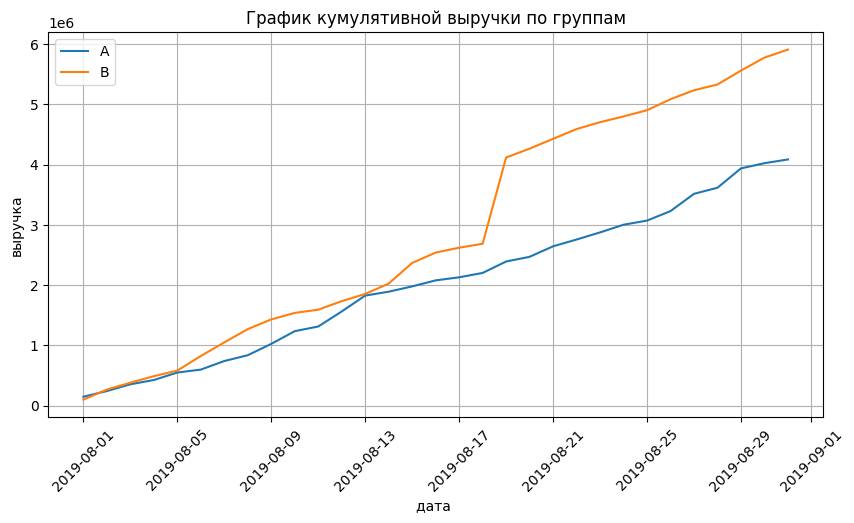

In [30]:
#датафрейм кумулятивным количеством заказов и кумулятивной выручкой по дням в группе А
cumulativeRevenueA = cumulativeData[cumulativeData['group']=='A'][['date','revenue', 'orders']]

# датафрейм с кумулятивным количеством заказов и кумулятивной выручкой по дням в группе B
cumulativeRevenueB = cumulativeData[cumulativeData['group']=='B'][['date','revenue', 'orders']]
plt.figure(figsize=(10,5))
# Строим график выручки группы А
plt.plot(cumulativeRevenueA['date'], cumulativeRevenueA['revenue'], label='A')

# Строим график выручки группы B
plt.plot(cumulativeRevenueB['date'], cumulativeRevenueB['revenue'], label='B')
plt.xticks(rotation=45)
plt.legend() 
plt.title('График кумулятивной выручки по группам')
plt.ylabel('выручка')
plt.xlabel('дата ')
plt.grid();

***Вывод: исходя из графика кумулятивной выручки по группам можно сделать вывод, что группа В значительно лучше группы А. Но надо отметить момент, где линия выручки группы В резко растет, можно сделать вывод, что есть аномальные значения, заказы с высокой стоимостью.*** 

## 3.2 Построим график кумулятивного среднего чека по группам. 

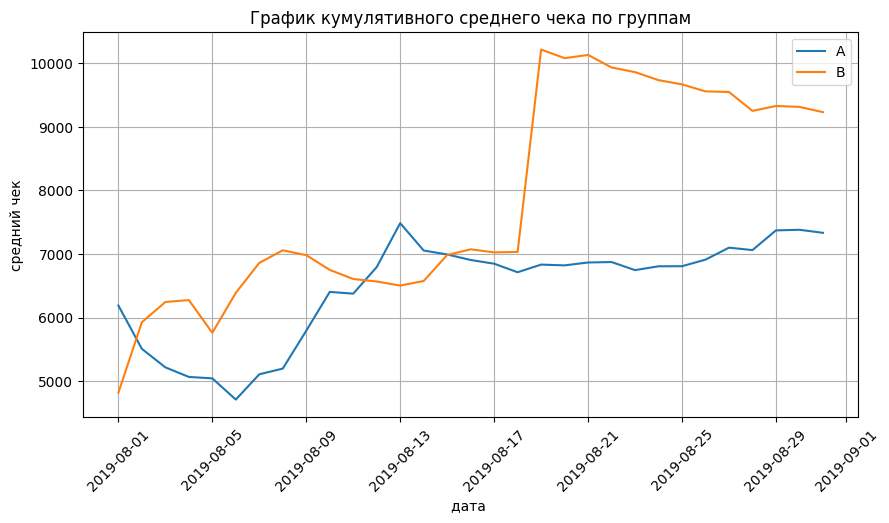

In [31]:
#строим график кумулятивного среднего чека по группам
plt.figure(figsize=(10,5))
plt.plot(cumulativeRevenueA['date'], cumulativeRevenueA['revenue']/cumulativeRevenueA['orders'], label='A')
plt.plot(cumulativeRevenueB['date'], cumulativeRevenueB['revenue']/cumulativeRevenueB['orders'], label='B')
plt.xticks(rotation=45)
plt.legend() 
plt.title('График кумулятивного среднего чека по группам')
plt.ylabel('средний чек')
plt.xlabel('дата ')
plt.grid();

***Вывод: исходя из графика кумулятивного среднего чека по группам, можно сказать, что группа В значительно лучше группы А. Но стоит обратить на резкий скачок линии группы В. Можно сделать вывод, что на значение кумулятивного среднего чека повлияли выбросы, аналогично графику кумулятивной выручки, затем линия группы В идет на спад.*** 

## 3.3 Построим график относительного изменения кумулятивного среднего чека группы B к группе A. 

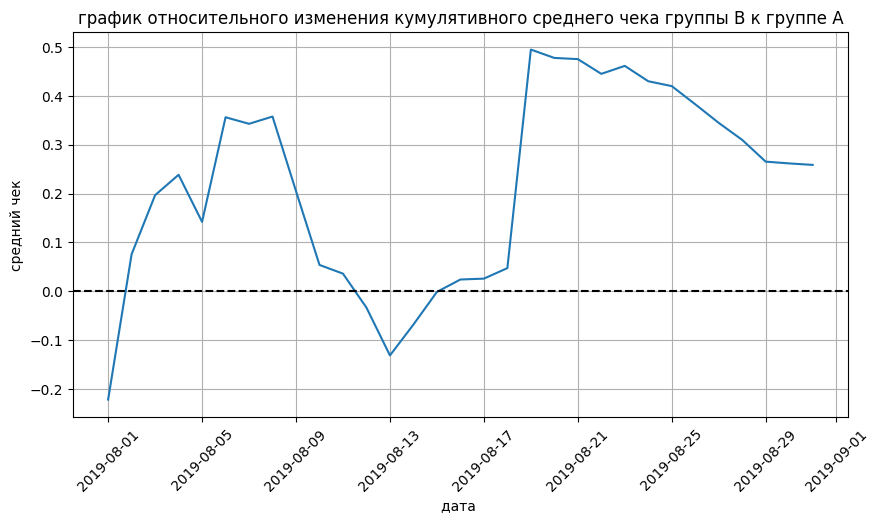

In [32]:
#датафрейм с кумулятивной выручкой групп А и В
mergedCumulativeRevenue = cumulativeRevenueA.merge(cumulativeRevenueB, left_on='date', right_on='date', how='left', suffixes=['A', 'B'])
plt.figure(figsize=(10,5))
# cтроим отношение средних чеков
plt.plot(mergedCumulativeRevenue['date'], (mergedCumulativeRevenue['revenueB']/mergedCumulativeRevenue['ordersB'])/(mergedCumulativeRevenue['revenueA']/mergedCumulativeRevenue['ordersA'])-1)

# добавляем ось X
plt.axhline(y=0, color='black', linestyle='--') 
plt.xticks(rotation=45)
plt.title('график относительного изменения кумулятивного среднего чека группы B к группе A')
plt.ylabel('средний чек')
plt.xlabel('дата ')
plt.grid()

***Вывод: исходя из графика можно сделать вывод, что изначально выручка группы В была меньше, затем повысилась, затем снова стала ниже группы А примерно в середине месяца, после идет резкий скачок, это аномально высокие заказы, влия\ющие на результат.Затем так же как и в предыдущем графике, средний чек группы В снижается.***

## 3.4 Построим график кумулятивного среднего количества заказов на посетителя по группам.

In [33]:
#добавляем столбец 'conversion' в датасет cumulativeData
cumulativeData['conversion'] = cumulativeData['orders']/cumulativeData['visitors']

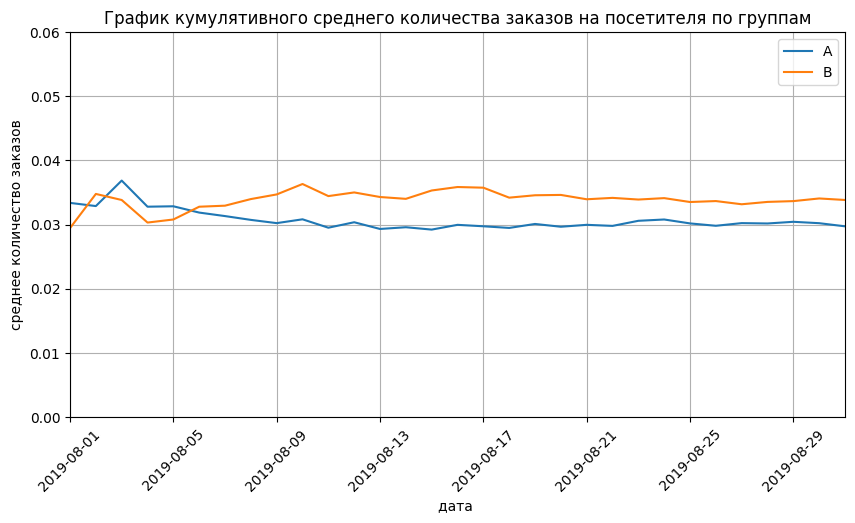

In [34]:
# отделяем данные по группе A
cumulativeDataA = cumulativeData[cumulativeData['group']=='A']

# отделяем данные по группе B
cumulativeDataB = cumulativeData[cumulativeData['group']=='B']
plt.figure(figsize=(10,5))
plt.plot(cumulativeDataA['date'], cumulativeDataA['conversion'], label='A')
plt.plot(cumulativeDataB['date'], cumulativeDataB['conversion'], label='B')
plt.legend()

# задаем масштаб осей
plt.axis([dt.datetime(2019, 8, 1), dt.datetime(2019, 8, 31), 0, 0.06])
plt.title('График кумулятивного среднего количества заказов на посетителя по группам')
plt.ylabel('среднее количество заказов')
plt.xlabel('дата ')
plt.xticks(rotation= 45)
plt.grid();

***Вывод: исходя из графика можно сделать вывод, что кумулятивное среднее количество заказов двух групп колебалось вначале, но стабилизировалось к концу. Кумулятивное среднее количество заказов группы В лучше чем группы А.***

## 3.5 Построим график относительного изменения кумулятивного среднего количества заказов на посетителя группы B к группе A. 

(18109.0, 18139.0, -0.3, 0.5)

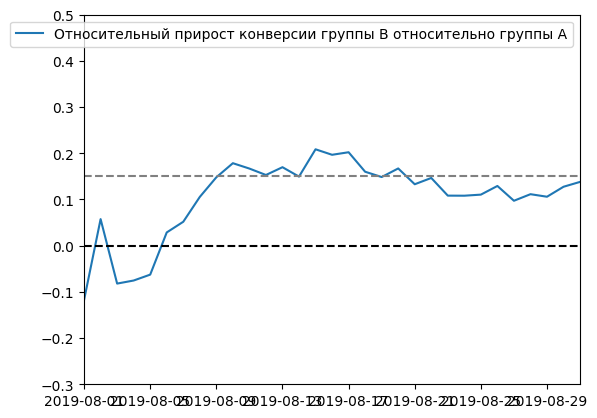

In [35]:
#датасет с кумулятивной конверсией 
mergedCumulativeConversions = cumulativeDataA[['date','conversion']].merge(cumulativeDataB[['date','conversion']], left_on='date', right_on='date', how='left', suffixes=['A', 'B'])
#строим график относительного изменения кумулятивного среднего количества заказов
plt.plot(mergedCumulativeConversions['date'], mergedCumulativeConversions['conversionB']/mergedCumulativeConversions['conversionA']-1, label="Относительный прирост конверсии группы B относительно группы A")
plt.legend()

plt.axhline(y=0, color='black', linestyle='--')
plt.axhline(y=0.15, color='grey', linestyle='--')
plt.axis(["2019-08-01", '2019-08-31', -0.3, 0.5])

***Вывод: Количество заказов групппы В было ниже группы А, затем стала увеличиваться, в середине месяца снова уменьшается, и к концу только начинает увеличиваться. В основном на 15% количество заказов больше группы В к группе А.***

## 3.6 Построим точечный график количества заказов по пользователям. 

In [36]:
#датафрейм с количеством заказов на пользователя
ordersByUsers = (
    orders.groupby('visitorId', as_index=False)
    .agg({'transactionId': 'nunique'}).sort_values(by='visitorId', ascending=False)
)
ordersByUsers.columns = ['userId', 'orders']

(array([937.,  64.,  17.,   3.,   6.,   0.,   0.,   1.,   1.,   2.]),
 array([ 1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11.]),
 <BarContainer object of 10 artists>)

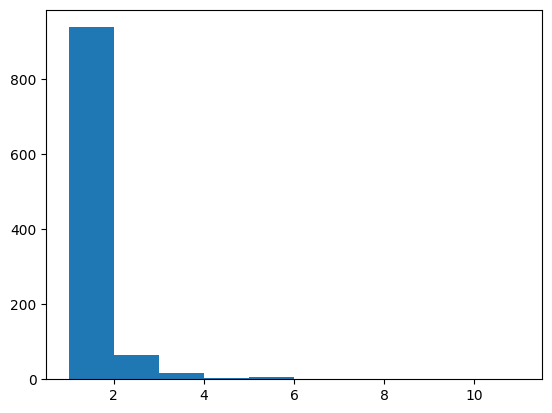

In [37]:
#сторим гистограмму количества заказов на пользователя 
plt.hist(ordersByUsers['orders']) 

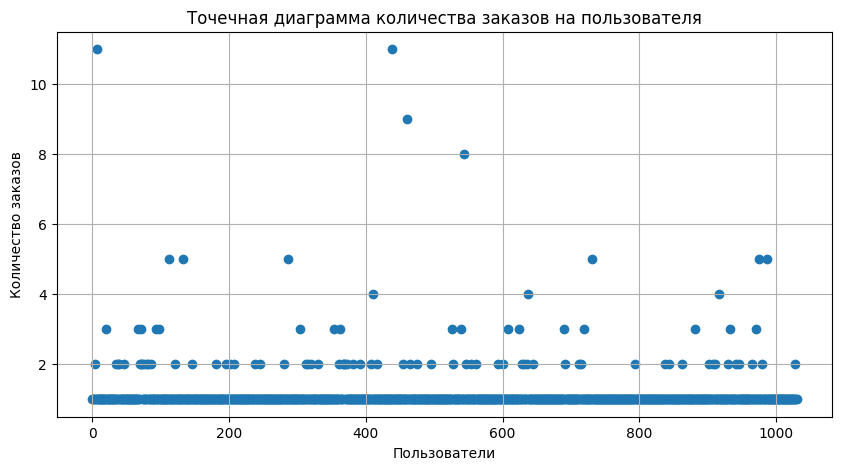

In [38]:
#сторим точечную диаграмму количества заказов на пользователя
x_values = pd.Series(range(0,len(ordersByUsers)))
plt.figure(figsize=(10, 5))
plt.scatter(x_values, ordersByUsers['orders']) 
plt.grid()
plt.title('Точечная диаграмма количества заказов на пользователя')
plt.ylabel('Количество заказов')
plt.xlabel('Пользователи');

***Вывод: исходя из гистограммы и точечной диаграммы можно сделать вывод, что в основном количество заказов варьируется от 1 до 11,чаще всего заказвают один или два раза. Реже 4.***

## 3.7 Посчитаем 95-й и 99-й перцентили количества заказов на пользователя. Определим границу для определения аномальных пользователей.

In [39]:
print(np.percentile(ordersByUsers['orders'], [95, 99]))

[2. 4.]


***Вывод: Заказов больше двух не более 5%, не заказов больше 4 не больше 1%. Границу для определения аномальных пользователей можно выбрать не более 4 заказов на пользователя.*** 

## 3.8 Построим точечный график стоимостей заказов. 

      transactionId   visitorId       date  revenue group
425   590470918      1920142716 2019-08-19  1294500  B   
1196  3936777065     2108080724 2019-08-15  202740   B   
858   192721366      1316129916 2019-08-27  93940    A   
1136  666610489      1307669133 2019-08-13  92550    A   
744   3668308183     888512513  2019-08-27  86620    B   
682   1216533772     4266935830 2019-08-29  78990    B   
662   1811671147     4266935830 2019-08-29  78990    A   
743   3603576309     4133034833 2019-08-09  67990    A   
1103  1348774318     1164614297 2019-08-12  66350    A   
1099  316924019      148427295  2019-08-12  65710    A   


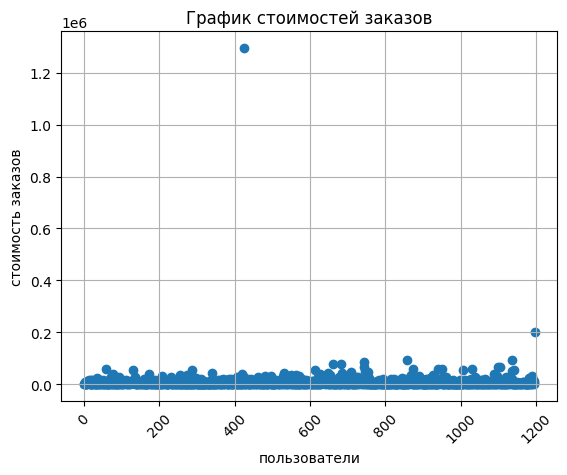

In [40]:
print(orders.sort_values(by='revenue', ascending=False).head(10))

x_values = pd.Series(range(0, len(orders['revenue'])))
plt.scatter(x_values, orders['revenue']) 
plt.xticks(rotation=45)
plt.grid()
plt.title('График стоимостей заказов')
plt.ylabel('стоимость заказов')
plt.xlabel('пользователи');

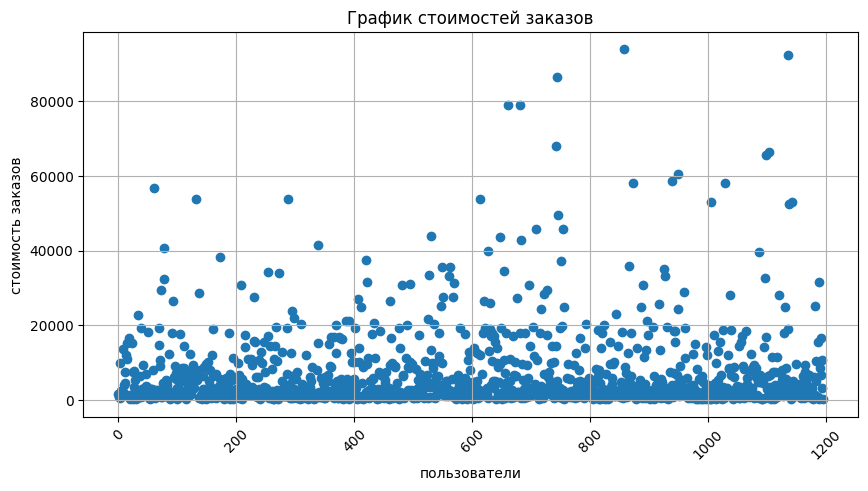

In [41]:
#построим график стоимостей заказов без учета заказов выше 100000
orders1 = orders[orders['revenue'] < 100000]
x_values = pd.Series(range(0, len(orders1['revenue'])))
plt.figure(figsize=(10,5))
plt.scatter(x_values, orders1['revenue']) 
plt.xticks(rotation=45)
plt.grid()
plt.title('График стоимостей заказов')
plt.ylabel('стоимость заказов')
plt.xlabel('пользователи');

***Вывод: исходя из графиков можно сделать вывод, что большинство заказов колеблятся в пределах от 40000. Есть аномальный заказ на 1200000, можно предположить, что именно он дает такие результаты группы В.***

## 3.9 Посчитаем 95-й и 99-й перцентили стоимости заказов. Определим границу для определения аномальных заказов.

In [42]:
print(np.percentile(orders['revenue'], [95, 99])) 

[28000.  58233.2]


***Вывод: заказов больше 28000 не больше 5%, заказов больше 58 000 не больше 1%. Границу для определния аномальных заказов можно выбрать в 40000***

## 3.10 Посчитаем статистическую значимость различий в среднем количестве заказов на посетителя между группами по «сырым» данным. 

***Сформулируем гипотезы.
Нулевая: различий в среднем количестве заказов между группами нет. Альтернативная: различия в среднем между группами есть. Уровень статистической значимости alpha = 0.05***

In [43]:
visitorsADaily = visitors[visitors['group'] == 'A'][['date', 'visitors']]
visitorsADaily.columns = ['date', 'visitorsPerDateA']

visitorsACummulative = visitorsADaily.apply(
    lambda x: visitorsADaily[visitorsADaily['date'] <= x['date']].agg(
        {'date': 'max', 'visitorsPerDateA': 'sum'}
    ),
    axis=1,
)
visitorsACummulative.columns = ['date', 'visitorsCummulativeA']

visitorsBDaily = visitors[visitors['group'] == 'B'][['date', 'visitors']]
visitorsBDaily.columns = ['date', 'visitorsPerDateB']

visitorsBCummulative = visitorsBDaily.apply(
    lambda x: visitorsBDaily[visitorsBDaily['date'] <= x['date']].agg(
        {'date': 'max', 'visitorsPerDateB': 'sum'}
    ),
    axis=1,
)
visitorsBCummulative.columns = ['date', 'visitorsCummulativeB']

ordersADaily = (
    orders[orders['group'] == 'A'][['date', 'transactionId', 'visitorId', 'revenue']]
    .groupby('date', as_index=False)
    .agg({'transactionId': pd.Series.nunique, 'revenue': 'sum'})
)
ordersADaily.columns = ['date', 'ordersPerDateA', 'revenuePerDateA']

ordersACummulative = ordersADaily.apply(
    lambda x: ordersADaily[ordersADaily['date'] <= x['date']].agg(
        {'date': 'max', 'ordersPerDateA': 'sum', 'revenuePerDateA': 'sum'}
    ),
    axis=1,
).sort_values(by=['date'])
ordersACummulative.columns = [
    'date',
    'ordersCummulativeA',
    'revenueCummulativeA',
]

ordersBDaily = (
    orders[orders['group'] == 'B'][['date', 'transactionId', 'visitorId', 'revenue']]
    .groupby('date', as_index=False)
    .agg({'transactionId': pd.Series.nunique, 'revenue': 'sum'})
)
ordersBDaily.columns = ['date', 'ordersPerDateB', 'revenuePerDateB']

ordersBCummulative = ordersBDaily.apply(
    lambda x: ordersBDaily[ordersBDaily['date'] <= x['date']].agg(
        {'date': 'max', 'ordersPerDateB': 'sum', 'revenuePerDateB': 'sum'}
    ),
    axis=1,
).sort_values(by=['date'])
ordersBCummulative.columns = [
    'date',
    'ordersCummulativeB',
    'revenueCummulativeB',
]

data = (
    ordersADaily.merge(
        ordersBDaily, left_on='date', right_on='date', how='left'
    )
    .merge(ordersACummulative, left_on='date', right_on='date', how='left')
    .merge(ordersBCummulative, left_on='date', right_on='date', how='left')
    .merge(visitorsADaily, left_on='date', right_on='date', how='left')
    .merge(visitorsBDaily, left_on='date', right_on='date', how='left')
    .merge(visitorsACummulative, left_on='date', right_on='date', how='left')
    .merge(visitorsBCummulative, left_on='date', right_on='date', how='left')
)
ordersByUsersA = (
    orders[orders['group'] == 'A']
    .groupby('visitorId', as_index=False)
    .agg({'transactionId': pd.Series.nunique})
)
ordersByUsersA.columns = ['userId', 'orders']

ordersByUsersB = (
    orders[orders['group'] == 'B']
    .groupby('visitorId', as_index=False)
    .agg({'transactionId': pd.Series.nunique})
)
ordersByUsersB.columns = ['userId', 'orders']

sampleA = pd.concat(
    [
        ordersByUsersA['orders'],
        pd.Series(
            0,
            index=np.arange(
                data['visitorsPerDateA'].sum() - len(ordersByUsersA['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
)

sampleB = pd.concat(
    [
        ordersByUsersB['orders'],
        pd.Series(
            0,
            index=np.arange(
                data['visitorsPerDateB'].sum() - len(ordersByUsersB['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
)

display("Статистическая значимость: {0:.3f}".format(stats.mannwhitneyu(sampleA, sampleB)[1]))

display("Относительный прирост заказов группы В к группе А: {0:.3f}".format(sampleB.mean() / sampleA.mean() - 1))

'Статистическая значимость: 0.017'

'Относительный прирост заказов группы В к группе А: 0.138'

***P-value значительно меньше 0.05 поэтому отвергаем нулевую гипотезу, исходя из анализа сырых данных можно сказать, что между группами есть статистические различия. Относительный прирост среднего количества заказов группы В к группе А составил 13 %.*** 

## 3.11 Посчитаем статистическую значимость различий в среднем чеке заказа между группами по «сырым» данным.\

 ***Сформируем гипотезу:
 Нулевая гипотеза: различий в среднем чеке между группами нет. Альтернативная гипотеза: различия в среднем чеке между группами есть. Уровень статистической значимости = 0.05***

In [44]:
print('Статистическая значимость: {0:.3f}'.format(stats.mannwhitneyu(orders[orders['group']=='A']['revenue'], orders[orders['group']=='B']['revenue'])[1]))
print('Относительный прирост заказов группы В к группе А: {0:.3f}'.format(orders[orders['group']=='B']['revenue'].mean()/orders[orders['group']=='A']['revenue'].mean()-1)) 

Статистическая значимость: 0.729
Относительный прирост заказов группы В к группе А: 0.259


***P-value больше 0,05 значит  не отвергаем нулевую гипотезу, можно сделать вывод, что различий в среднем чеке заказа нет. Относительный прирост среднего чека группы В на 25% не является значимым, получено случайно.***

## 3.12 Посчитаем статистическую значимость различий в среднем количестве заказов на посетителя между группами по «очищенным» данным.

***Сформулируем гипотезы: Нулевая: различий в среднем количестве заказов по очищенным данным между группами нет. Альтернативная: различия в среднем между группами по очищенным данным есть. Уровень статистической значимости alpha = 0.05***

In [45]:
usersWithManyOrders = pd.concat(
    [
        ordersByUsersA[ordersByUsersA['orders'] >= 4]['userId'],
        ordersByUsersB[ordersByUsersB['orders'] >= 4]['userId'],
    ],
    axis=0,
)
usersWithExpensiveOrders = orders[orders['revenue'] > 40000]['visitorId']
abnormalUsers = (
    pd.concat([usersWithManyOrders, usersWithExpensiveOrders], axis=0)
    .drop_duplicates()
    .sort_values()
)
print(abnormalUsers.head(5))

1099    148427295
18      199603092
23      237748145
684     358944393
648     382846391
dtype: int64


In [46]:
sampleAFiltered = pd.concat(
    [
        ordersByUsersA[
            np.logical_not(ordersByUsersA['userId'].isin(abnormalUsers))
        ]['orders'],
        pd.Series(
            0,
            index=np.arange(
                data['visitorsPerDateA'].sum() - len(ordersByUsersA['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
)

sampleBFiltered = pd.concat(
    [
        ordersByUsersB[
            np.logical_not(ordersByUsersB['userId'].isin(abnormalUsers))
        ]['orders'],
        pd.Series(
            0,
            index=np.arange(
                data['visitorsPerDateB'].sum() - len(ordersByUsersB['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
) 
print('Статистическая значимость: {0:.3f}'.format(stats.mannwhitneyu(sampleAFiltered, sampleBFiltered)[1]))
print('Относительный прирост заказов группы В к группе А: {0:.3f}'.format(sampleBFiltered.mean()/sampleAFiltered.mean()-1)) 

Статистическая значимость: 0.009
Относительный прирост заказов группы В к группе А: 0.164


***Вывод: по очищенным данным относительный прирост среднего количества заказов составил 16%, это 3% больше чем по сырым данным, p-value  меньше 0.05 значит можно сказать, что между группами есть статистические различия.***

## 3.13 Посчитайте статистическую значимость различий в среднем чеке заказа между группами по «очищенным» данным. Сделайте выводы и предположения.

***Сформируем гипотезу: Нулевая гипотеза: различий в среднем чеке по очищенным данным между группами нет. Альтернативная гипотеза: различия в среднем чеке по очищенным данным между группами есть. Уровень статистической значимости = 0.05***

In [47]:
print(
    'Статистическая значимость: {0:.3f}'.format(
        stats.mannwhitneyu(
            orders[
                np.logical_and(
                    orders['group'] == 'A',
                    np.logical_not(orders['visitorId'].isin(abnormalUsers)),
                )
            ]['revenue'],
            orders[
                np.logical_and(
                    orders['group'] == 'B',
                    np.logical_not(orders['visitorId'].isin(abnormalUsers)),
                )
            ]['revenue'],
        )[1]
    )
)

print(
    "Относительный прирост заказов группы В к группе А: {0:.3f}".format(
        orders[
            np.logical_and(
                orders['group'] == 'B',
                np.logical_not(orders['visitorId'].isin(abnormalUsers)),
            )
        ]['revenue'].mean()
        / orders[
            np.logical_and(
                orders['group'] == 'A',
                np.logical_not(orders['visitorId'].isin(abnormalUsers)),
            )
        ]['revenue'].mean()
        - 1
    )
) 

Статистическая значимость: 0.711
Относительный прирост заказов группы В к группе А: 0.060


***Вывод: По очищенным данным p-value так же больше 0.05, значит не отвергаем нулевую гипотезу, различий в среднем чеке между группами нет. Прирост группы В составил 6%, по сырым данным прирост составил 25%. Данные изменились после удаления выбросов.***  

## 3.14 Примите решение по результатам теста и объясните его. Варианты решений:
1. Остановить тест, зафиксировать победу одной из групп.
2. Остановить тест, зафиксировать отсутствие различий между группами.
3. Продолжить тест.

***Вывод анализа А/В теста : Статистические различия есть в среднем количестве заказов, но нет в среднем чеке между группами. Прирост в среднем чеке составил 6%, можно сказать, что при внедрении изменения тестируемого в группе В, можно получить увеличения количества заказов, которое приведет к увеличению выручки. По итогам анализа А/В теста побеждает группа В.***